# 3章 クロスバリデーション

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy import stats
from numpy.random import randn

# 35

In [6]:
n=1000;p=5
X = np.insert(randn(n, p), 0, 1, axis=1)
beta = randn(p + 1).reshape(-1, 1)
y = X@beta + 0.2 * randn(n).reshape(-1,1)
y = y[:, 0]

In [7]:
# 通常のクロスバリデーション
def cv_linear(X,y,K):
    n=len(y)
    m=int(n/K)
    S=0
    for j in range(K):
        test=list(range(j*m,(j+1)*m)) # テストデータの添え字 
        train=list(set(range(n))-set(test))     # 訓練データの添え字
        beta=np.linalg.inv(X[train,].T@X[train,])@X[train,].T@y[train]
        e=y[test]-X[test,]@beta
        S=S+np.linalg.norm(e)**2
    return S/n

In [8]:
# 高速版クロスバリデーション
def cv_fast(X,y,K):
    n=len(y)
    m=int(n/K)
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    I=np.diag(np.repeat(1,n))
    e=(I-H)@y
    Ik=np.diag(np.repeat(1,m))
    S=0
    for j in range(k):
        test=np.arange(j*m,(j+1)*m,1,dtype=int)
        a = np.linalg.inv(Ik-H[test,test])@e[test]
        S += a.T @ a
    return S/n

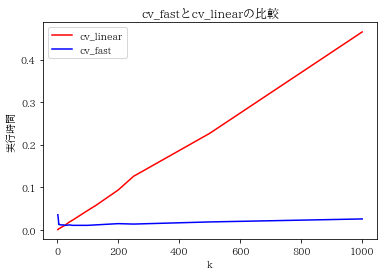

,cv_linear,cv_fast
2,0.040518,0.039618
4,0.040687,0.041698
5,0.040348,0.051890
8,0.040388,0.045668
10,0.040247,0.042818
20,0.040303,0.040998
25,0.040267,0.040578
40,0.040283,0.040597
50,0.040261,0.040523
100,0.040235,0.040377


In [18]:
import time

U_l=[]; V_l=[]; U_f=[]; V_f=[]
errors = []
for k in range(2,n+1,1):
    if n%k==0:
        # 通常版
        t1=time.time() # 処理前の時刻
        error_linear = cv_linear(X,y,k)
        t2=time.time() #処理後の時刻
        U_l.append(k)
        V_l.append(t2-t1)
        # 高速版
        t1=time.time() 
        error_fast = cv_fast(X,y,k)
        t2=time.time() 
        U_f.append(k)
        V_f.append(t2-t1)
        
        errors.append([error_linear, error_fast])
        
plt.plot(U_l,V_l,c="red",label="cv_linear")
plt.plot(U_f,V_f,c="blue",label="cv_fast")
plt.legend()  
plt.xlabel("k")
plt.ylabel("実行時間")
plt.title("cv_fastとcv_linearの比較")
plt.show()

# 結果が一致しているか確認
df_error = pd.DataFrame(errors, columns=["cv_linear", "cv_fast"] ,index=U_f)
display(df_error)

# 36

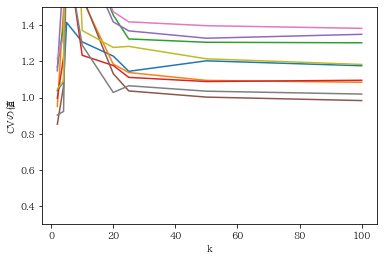

In [25]:
n=100;p=5
plt.ylim(0.3,1.5)
plt.xlabel("k")
plt.ylabel("CVの値")
for j in range(2,11,1):
    X=randn(n,p)
    X=np.insert(X, 0, 1, axis=1)
    beta=randn(p+1)
    y=X@beta+randn(n)
    U = []; V = []
    for k in range(2,n+1,1):
        if n%k==0:
            U.append(k)
            V.append(cv_fast(X,y,k))
    plt.plot(U,V)        

# 37

knn再掲

In [27]:
# スクラッチ

# 各点とのノルムを計算する関数
def _get_norm(X, y, target, k):
    distance = np.full(X.shape[0], np.inf)
    for i in range(X.shape[0]):
        # ノルム計算
        distance[i] = np.linalg.norm(target - X[i,:], ord=2)
    return y[np.argsort(distance)]

# k近傍法(1つの入力に対して)
def _knn_one(X, y, target, k):
    mode = [0,0]
    # ノルム計算
    nn = _get_norm(X, y, target, k)
    while len(mode)>1:
        # 最頻値獲得
        count = np.bincount(nn[:k])
        mode = [idx for idx, value in enumerate(count) if value==max(count)]
        k -= 1
    return mode[0]

# k近傍法(１つ以上の入力に対して)
def knn(X, y, targets, k):
    # 入力が１つの場合
    if len(targets.shape)==1:
        assert X.shape[1]==targets.shape[0], \
            "Data size dose not match."
        return _knn_one(X, y, targets, k)
    # 入力が２つ以上の場合
    else:
        modes = np.empty(targets.shape[0])
        assert X.shape[1]==targets.shape[1], \
            "Data size dose not match."
        for idx in range(targets.shape[0]):
            modes[idx] = _knn_one(X, y, targets[idx,:], k)
        return modes

In [26]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.target_names
x=iris.data
y=iris.target

n=x.shape[0]
index=np.random.choice(n, n, replace=False) # 並び替える
x=x[index,]
y=y[index]

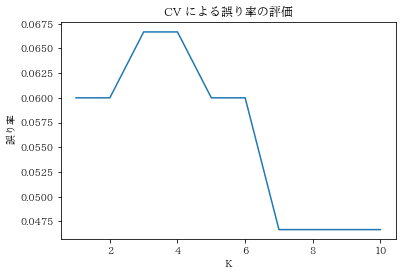

In [29]:
U = []
V = []
top_seq=list(range(0,135,10))
for k in range(1,11,1):
    S=0
    for top in top_seq:
        test=list(range(top,top+15))
        train=list(set(range(150))-set(test))
        knn_ans=knn(x[train,],y[train],x[test,],k=k)
        ans=y[test]
        S=S+np.sum(knn_ans!=ans)
    S=S/n
    U.append(k)
    V.append(S)
plt.plot(U,V)
plt.xlabel("K")
plt.ylabel(" 誤り率")
plt.title("CV による誤り率の評価")
plt.show()

# 38

In [64]:
def bt(df, f, r):
    m = df.shape[0]
    org = f(df, np.arange(m))  # 空欄(1)
    u = []
    for j in range(r):
        idx = np.random.choice(m, m, replace=True)  # 空欄(2)
        u.append(f(df, idx))
    
    return {'original':org, 'bias':np.mean(u)-org, 'stderr':np.std(u)}

In [65]:
def func_1(data, idx):
    X = data[idx, 0]
    Y = data[idx, 1]
    
    
    return (np.var(Y)-np.var(X))/(np.var(X)+np.var(Y)-2*np.cov(X,Y)[0,1])

In [66]:
portfolio = np.loadtxt('./distribution/Portfolio.csv', delimiter=",", skiprows=1)
bt(portfolio, func_1, 1000)

{'original': 0.15330230333295436,
 'bias': 0.00788326341424675,
 'stderr': 0.1898859944115764}

# 39

In [32]:
from sklearn import linear_model

In [34]:
df=np.loadtxt("./distribution/crime.txt",delimiter="\t")

reg = linear_model.LinearRegression()
X = df[:, [2,3]]
y = df[:, 0]
reg.fit(X, y)
reg.coef_

array([11.8583308 , -5.97341169])

In [67]:
for j in range(3):
    def func_2(data,index):
        X=data[index,2:4];y=data[index,0]
        reg.fit(X,y)
        if j==0:
            return reg.intercept_
        else:
            return reg.coef_[j-1]
    print (bt(df,func_2,1000))

{'original': 621.4260363802889, 'bias': 36.69361654339036, 'stderr': 222.20238289328958}
{'original': 11.858330796711094, 'bias': -0.5099989760246757, 'stderr': 3.4237985004260083}
{'original': -5.973411688164963, 'bias': -0.1723869203244437, 'stderr': 3.271319379225455}


1行目の出力  ： 回帰式の切片の標準偏差<br>
2,3行目の出力： 回帰係数の標準偏差